# Detrend model data

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd

In [2]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
cesm2_path        = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals             = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cmip6_cvals       = cvals + 'cmip6/'
############
pi_year  = 1865
eoc_year = 2086
#
doy  = 211
#############################
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)

In [3]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 

In [4]:
def detrend_all(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.mean('member').polyfit(dim='year',deg=1)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

In [5]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [6]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

In [7]:
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'
pi_year   = 1865
eoc_year  = 2071
doy       = 211 # day_of_year
date      = 'Jul30'

In [8]:
cluster

Dashboard: http://10.0.2.2:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.2.2:42991,Workers: 0
Dashboard: http://10.0.2.2:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load CESM data

In [9]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 2.35 s, sys: 590 ms, total: 2.94 s
Wall time: 3.39 s


In [10]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgpi   = ds_hist.TREFHTMX.sel(method='nearest').sel(time=slice(pi_year0,pi_year1))
tgeoc  = ds_ssp.TREFHTMX.sel(method='nearest').sel(time=slice(ic_year0,ic_year1))

CPU times: user 375 ms, sys: 8.94 ms, total: 384 ms
Wall time: 372 ms


In [11]:
tgpi   = tgpi.chunk({'member':100,'lat':40,'lon':60})
tgeoc  = tgeoc.chunk({'member':100,'lat':40,'lon':60})
tdgpi  = to_daily(tgpi)
tdgeoc = to_daily(tgeoc)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

In [12]:
tdgeoc

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, member: 100, year: 30,
                              dayofyear: 365)>
dask.array<reshape, shape=(192, 288, 100, 30, 365), dtype=float32, chunksize=(40, 60, 100, 10, 365), chunktype=numpy.ndarray>
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

## Detrend data

In [13]:
%%time
for start_day in range(1, 366, 73):  # Loop through days, 73 at a time
    end_day = min(start_day + 72, 365)  # Ensure we don't go beyond the last day
    print(start_day,end_day)

1 73
74 146
147 219
220 292
293 365
CPU times: user 199 µs, sys: 36 µs, total: 235 µs
Wall time: 186 µs


In [14]:
# %%time
# for start_day in range(1, 366, 73):  # Loop through days, 73 at a time
#     end_day = min(start_day + 72, 365)  # Ensure we don't go beyond the last day
#     print(start_day,end_day)
    
#     # Select the subset of data for the current range of days
#     tdgpi_subset = tdgpi.sel(dayofyear=slice(start_day, end_day))
    
#     # Apply the detrending function
#     tdgpi_detrended = detrend_all(tdgpi_subset, pi_year)
    
#     # Define the filename based on the current day range
#     filename = f'pi_detrended_data_days_{start_day}_{end_day}.zarr'
    
#     # Write the detrended subset to a Zarr file
#     tdgpi_detrended = tdgpi_detrended.chunk({'lat':8})
#     tdgpi_detrended.rename('detrended_tmax').to_dataset().to_zarr(cvals+filename, mode='w')
#     print('Dataset saved')
# print("All subsets processed and saved.")

In [15]:
# Construct the file pattern to match all relevant Zarr files
file_pattern = cvals+ f'/pi_detrended_data_days_*.zarr'

# List all matching Zarr file directories
zarr_files = glob.glob(file_pattern)

# Open and concatenate the Zarr files along the 'dayofyear' dimension
# Note: Adjust open_mfdataset parameters as needed for your specific case
tdgpi_detrended = xr.open_mfdataset(zarr_files, concat_dim='dayofyear', combine='nested',engine='zarr')
# tdgpi_detrended = tdgpi_detrended.drop_duplicates(dim='dayofyear')
tdgpi_detrended = tdgpi_detrended.detrended_tmax
tdgpi_detrended = tdgpi_detrended.chunk({'year':30})
tdgpi_detrended 

<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100, year: 30,
                                    dayofyear: 365)>
dask.array<rechunk-merge, shape=(192, 288, 100, 30, 365), dtype=float64, chunksize=(8, 60, 100, 30, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 220 221 222 223 224 225 ... 142 143 144 145 146
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [16]:
# %%time
# tdgpi_detrended.to_dataset().to_zarr(cvals+'pi_detrended.zarr',mode='w')

In [17]:
# %%time
# ### Test####
# tdgpi_detrended = xr.open_zarr(cvals+'pi_detrended.zarr').detrended_tmax
# tdgpi_det_chic  = tdgpi_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest')\
#                    .sel(dayofyear=1).mean('member')
# tdgpi_chic      = tdgpi.sel(lat=chic_lat,lon=chic_lon,method='nearest')\
#                    .sel(dayofyear=1).mean('member')
# tdgpi_det_chic.plot()
# tdgpi_chic.plot()

#### EOC data

In [18]:
# %%time
# for start_day in range(1, 366, 73):  # Loop through days, 73 at a time
#     end_day = min(start_day + 72, 365)  # Ensure we don't go beyond the last day
#     print(start_day,end_day)
#     # Select the subset of data for the current range of days
#     tdgeoc_subset = tdgeoc.sel(dayofyear=slice(start_day, end_day))
    
#     # Apply the detrending function
#     tdgeoc_detrended = detrend_all(tdgeoc_subset, eoc_year)
    
#     # Define the filename based on the current day range
#     filename = f'eoc_detrended_data_days_{start_day}_{end_day}.zarr'
    
#     # Write the detrended subset to a Zarr file
#     tdgeoc_detrended = tdgeoc_detrended.chunk({'lat':8,'year':30})
#     tdgeoc_detrended.rename('detrended_tmax').to_dataset().to_zarr(cvals+filename, mode='w')
#     print('Dataset saved')
# print("All subsets processed and saved.")

1 73
Dataset saved
74 146
Dataset saved
147 219
Dataset saved
220 292
Dataset saved
293 365
Dataset saved
All subsets processed and saved.
CPU times: user 1h 13min 38s, sys: 3min 22s, total: 1h 17min 1s
Wall time: 2h 39min 35s


In [19]:
# Construct the file pattern to match all relevant Zarr files
file_pattern = cvals+ f'/eoc_detrended_data_days_*.zarr'

# List all matching Zarr file directories
zarr_files = glob.glob(file_pattern)

# Open and concatenate the Zarr files along the 'dayofyear' dimension
# Note: Adjust open_mfdataset parameters as needed for your specific case
tdgeoc_detrended = xr.open_mfdataset(zarr_files, concat_dim='dayofyear', combine='nested',engine='zarr')
tdgeoc_detrended = tdgeoc_detrended.detrended_tmax
tdgeoc_detrended

<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100, year: 30,
                                    dayofyear: 365)>
dask.array<concatenate, shape=(192, 288, 100, 30, 365), dtype=float64, chunksize=(8, 60, 100, 30, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 286 287 288 289 290 291 292
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [20]:
# %%time
# tdgeoc_detrended.to_dataset().to_zarr(cvals+'eoc_detrended.zarr',mode='w')

CPU times: user 1min 25s, sys: 4.06 s, total: 1min 29s
Wall time: 3min 7s


In [21]:
%%time
### Test####
tdgeoc_detrended = xr.open_zarr(cvals+'eoc_detrended.zarr').detrended_tmax
tdgeoc_detrended

CPU times: user 123 ms, sys: 74.4 ms, total: 198 ms
Wall time: 205 ms


<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100, year: 30,
                                    dayofyear: 365)>
dask.array<open_dataset-3f56456cd39d478fcf0e1a269b32bfa2detrended_tmax, shape=(192, 288, 100, 30, 365), dtype=float64, chunksize=(8, 60, 100, 30, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 286 287 288 289 290 291 292
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

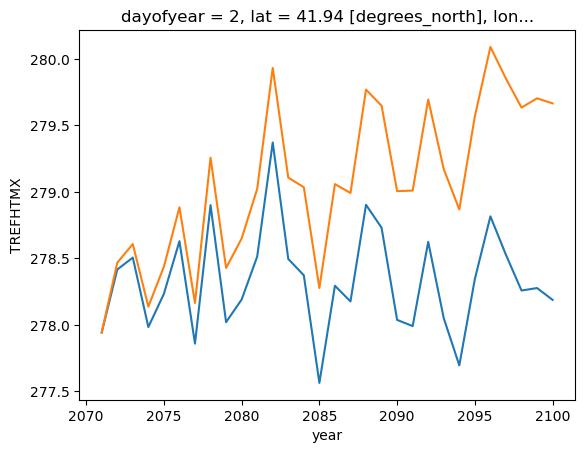

In [22]:

tdgeoc_det_chic  = tdgeoc_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                   .sel(dayofyear=2).mean('member')
tdgeoc_chic      = tdgeoc.sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                   .sel(dayofyear=2).mean('member')
tdgeoc_det_chic.plot()
tdgeoc_chic.plot()

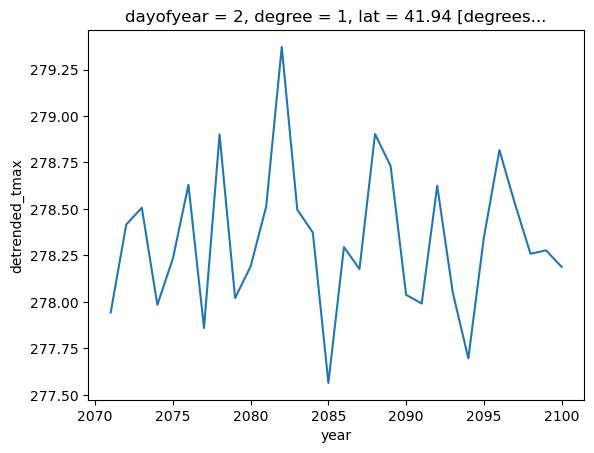

In [23]:
tdgeoc_det_chic.plot()